#Molecular Dynamics Simulation Using the Lennard-Jones Potential

This Python script simulates a molecular system using the Lennard-Jones (LJ) potential. It includes functions for computing LJ potential energy, system energy, and interatomic forces. The simulation initializes particle velocities, performs energy minimization using the Steepest Descent (SD) method, and evolves the system using the velocity-Verlet algorithm in an NVE ensemble. The script saves the minimized positions and generates a trajectory for 1000 time steps

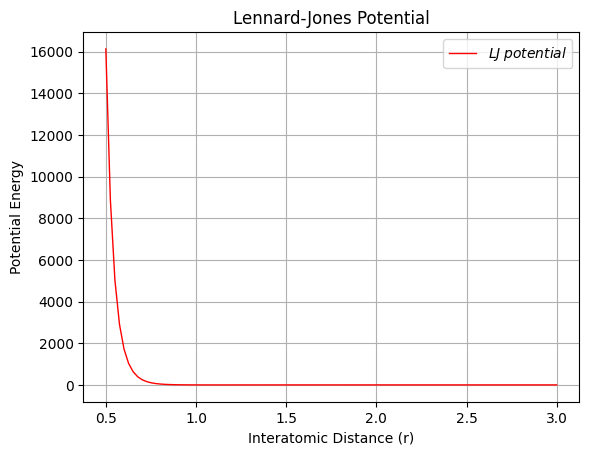

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def lj_pe(r, eps, sigma):
    return 4*eps*((sigma/r)**12 - (sigma/r)**6)

r = np.linspace(0.5, 3, 100)

plt.plot(r, lj_pe(r, 1, 1), 'r-', linewidth=1, label=r"$LJ\; potential$")
plt.xlabel("Interatomic Distance (r)")
plt.ylabel("Potential Energy")
plt.title("Lennard-Jones Potential")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann
import random

# LJ potential energy (part 1)
def lj_pe(r, eps, sigma):
    return 4*eps*((sigma/r)**12 - (sigma/r)**6)

#potential energy of the complete LJ system (part 2)
def lj_system_energy(positions, species, box_size, eps, sigma):

    N = positions.shape[0] #Number of atoms
    energy = 0.0

    for i in range(N):
        for j in range(i+1, N):
            dx = positions[i] - positions[j]
            dx = dx - box_size * np.round(dx/box_size)
            r = np.linalg.norm(dx)

            # Check if the distance is within the interaction cutoff
            if r <= 2.5 * sigma[species[i], species[j]]: #cutoff radius(rc = 2.5 * sigma[species[i], species[j]])

                eps_ij = eps[species[i], species[j]]
                sigma_ij = sigma[species[i], species[j]]

                energy = energy + lj_pe(r, eps_ij, sigma_ij)

    return energy

#Load the configuration
positions = np.load("LJ_A80B20_3D_100_pos.npy")
species = np.load("LJ_A80B20_3D_100_species.npy")

#LJ parameters
eps = np.array([[1.0, 1.5], [1.5, 0.5]])
sigma = np.array([[1.0, 0.8], [0.8, 0.88]])

#Set the simulation parameters
box_size = 4.3679
temperature = 2.0
mass = 1.0
dt = 0.003

#Calculate the potential energy of the system
energy = lj_system_energy(positions, species, box_size, eps, sigma)

print("The potential energy of the LJ system is:", energy)


The potential energy of the LJ system is: -792.9939374989531


In [6]:
#Minimization using SD method

x = positions[:,0]
y = positions[:,1]
z = positions[:,2]

# Define the parameters
N = positions.shape[0]

# Initial potential energy
U = lj_system_energy(positions, species, box_size, eps, sigma)

##
alpha = 0.01
max_iterations = 50

#SD method
for iteration in range(max_iterations):
    force = np.zeros((N, 3))
    for i in range(N):
        for j in range(i+1, N):
           dx = positions[i] - positions[j]
           dx = dx - box_size * np.round(dx/box_size)
           r = np.linalg.norm(dx)
            #Calculate the force between the particles using the LJ potential
           if r < 2.5 * sigma[species[i], species[j]]:
                f = 24 * eps[species[i], species[j]] * (2 * (sigma[species[i], species[j]]**12) / (r**13) - (sigma[species[i], species[j]]**6) / (r**7))
                force[i] = force[i] + f * dx
                force[j] = force[j] - f * dx

    x = x + alpha * force[:, 0]
    y = y + alpha * force[:, 1]
    z = z + alpha * force[:, 2]

  # Current potential energy
    U_new = 0
    for i in range(N):
        for j in range(i+1, N):
            r = np.array([x[i]-x[j], y[i]-y[j], z[i]-z[j]])
            r_norm = np.linalg.norm(r)
            if r_norm <= 2.5 * sigma[species[i], species[j]]:
                eps_ij = eps[species[i], species[j]]
                sigma_ij = sigma[species[i], species[j]]
                U_new = U_new + lj_pe(r, eps_ij, sigma_ij)

    if np.linalg.norm(U_new - U) < 1e-6:
        print(f"Converged after {iteration+1} iterations")
        break

# Update the potential energy
        U = U_new

np.savetxt('positions_minimized.npy', np.column_stack((x, y, z)))



In [8]:
#Initial velocities (part 4)
def init_vel(positions, temperature, mass):

#Gaussian distribution
    sigma = np.sqrt(Boltzmann * temperature / mass)
    velocities = np.random.normal(loc=0.0, scale=sigma, size=(100, 3))

    return velocities

#using function
velocities = init_vel(positions, temperature, mass)


In [9]:
#LJ force and acceleration (part 5)
def lj_force(positions, box_size, species, eps, sigma):

    force = np.zeros_like(positions)
    acceleration = np.zeros_like(positions)

    N = positions.shape[0] #Number of atoms

    for i in range(N):
        for j in range(i+1, N):
            dx = positions[i] - positions[j]
            dx = dx - box_size * np.round(dx/box_size)
            r = np.linalg.norm(dx)

            #Calculate the force between the particles using the LJ potential
            if r < 2.5 * sigma[species[i], species[j]]:
                f = 24 * eps[species[i], species[j]] * (2 * (sigma[species[i], species[j]]**12) / (r**13) - (sigma[species[i], species[j]]**6) / (r**7))
                force[i] = force[i] + f * dx
                force[j] = force[j] - f * dx

    #calculate the acceleration on each particle
    acceleration = force / mass

    return force, acceleration

In [10]:
#NVE Simulation for one time step (part 5)
def lj_simulation_step(positions, velocities, box_size, species, eps, sigma, dt, mass):

    #current
    force, acceleration = lj_force(positions, box_size, species, eps, sigma)

    #update the positions using the velocity-Verlet algorithm
    positions = positions + velocities * dt + 0.5 * acceleration * dt**2

    #updated
    new_force, new_acceleration = lj_force(positions, box_size, species, eps, sigma)

    #update the velocities using the velocity-Verlet algorithm
    velocities = velocities + 0.5 * (acceleration + new_acceleration) * dt

    return positions, velocities


In [ ]:
#NVE Simulation for 1000 time steps (part 6)
trajectory = np.zeros((1000, 100, 3))

#Run simulation for 100num_rows0 steps
for step in range(1000):
    # Perform one step of simulation
    positions, velocities = lj_simulation_step(positions, velocities, box_size, species, eps, sigma, dt, mass)

    #
    trajectory[step] = positions

# Save trajectory
np.save('lj_trajectory.npy', trajectory)